<a href="https://colab.research.google.com/github/raquelcarmo/tropical_cyclones/blob/main/src/code/TC_parametric_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TC Preprocessing

Script to analyse parametric model.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# getting in the directory 
%ls
# insert your path
%cd /content/drive/My\ Drive/ESRIN_PhiLab/Tropical_Cyclones/data/parametric_model
%ls

2D_wind_profile.png                 Revised_1D_wind_profile.png
2D_wind_profile_with_IA_and_TS.png  Vortex.png
2D_wind_profile_with_IA.png         Vortex_with_IA_and_TS.png
Inflow_Angle.png                    Vortex_with_IA.png
old_wrong/
/content/drive/My Drive/ESRIN_PhiLab/Tropical_Cyclones/data/parametric_model
2D_wind_profile.png                 Revised_1D_wind_profile.png
2D_wind_profile_with_IA_and_TS.png  Vortex.png
2D_wind_profile_with_IA.png         Vortex_with_IA_and_TS.png
Inflow_Angle.png                    Vortex_with_IA.png
old_wrong/


In [ ]:
# general import
import bokeh.io
bokeh.io.output_notebook()
import pandas as pd
import xarray as xr
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import glob
import numpy as np
import cv2
import math
from scipy import ndimage
from google.colab.patches import cv2_imshow
from PIL import Image
import random

Source: 
*   https://stackoverflow.com/questions/36501494/converting-1d-radial-profil-to-2d-image
*   https://stackoverflow.com/questions/48935153/plotting-1-d-dataset-with-radial-symmetry-around-the-origin-in-python

##1D Parametric model

In [ ]:
# given
R = 286.9
RHs = 0.9
SST = 28

# to compute
Pns = 1005
Pcs = 950
Vns = 17
Rn = 300
R_Vms = 20
dPcst = 3
Phi = 20
Vt = 5

In [ ]:
# parametric model
"""
Subscript s refers to surface values (at a nominal height of 10m)
  Vm : maximum wind at gradient level (in m/s);
  R_Vm : radius of maximum wind (in km);
  x : scaling parameter that adjusts the profile shape;
  Pns : external pressure
  Pcs : central pressure
  Pms : surface pressure at radius of maximum wind;
  deltaPs : pressure drop from a defined external pressure Pns to the cyclone center Pcs (in hPa);
  dPcst : intensity change (in hPa/s)
  e : base of natural logarithms;
  b : scaling parameter defining the proportion of pressure gradient near the maximum wind radius (aka maximum wind speed for a given pressure drop);
  Bs = b * np.power(Gs, x), where Gs : reduction factor for gradient-to-surface winds;
  Phi : absolute value of latitude (in degrees);
  Vt : cyclone translation speed (in m/s);
  Rho_ms : surface air density at maximum wind (in kg/m3);
  Qs : surface moisture (in g/kg);
  R : gas constant fo dry air (in J/(kg*K));
  Tvs : virtual surface temperature (in K);
  Ts : surface temperature (in °C);
  SST : sea surface temperature (in °C);
  RHs : surface relative humidity (=0.9 in the absence of direct observations);
"""

def equation_wind_profile(r, Vms, R_Vms, Bs, x):
  # equation 6 from Holland
  factor = np.power((R_Vms/r), Bs) # varies with r
  return Vms * np.power((factor * np.exp(1-factor)), x)


def compute_wind_profile(r, R, RHs, SST, R_Vms, Rn, Pcs, Pns, dPcst, Phi, Vt): 

  # equation 8 from Holland
  deltaPs = Pns - Pcs
  x = 0.6 * (1-(deltaPs/215))
  Bs = -4.4 * (10**-5) * (deltaPs**2) + 0.01 * deltaPs + 0.03 * dPcst - 0.014 * Phi + 0.15 * (Vt**x) + 1.0
  e = np.exp(1)

  # equation 9 from Holland
  Ts = SST - 1
  Pms = Pcs + deltaPs * np.exp(-(R_Vms/R_Vms)**Bs) # equation 2 from Holland
  Qs = RHs * (3.802/(100*Pms)) * np.exp((17.67*Ts)/(243.5+Ts))
  Tvs = (Ts + 273.15)*(1 + 0.81*Qs)
  Rho_ms = 100 * Pms / (R * Tvs)

  Vms = np.sqrt((100 * Bs * deltaPs)/(Rho_ms * e))

  return equation_wind_profile(r, Vms, R_Vms, Bs, x)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in multiply


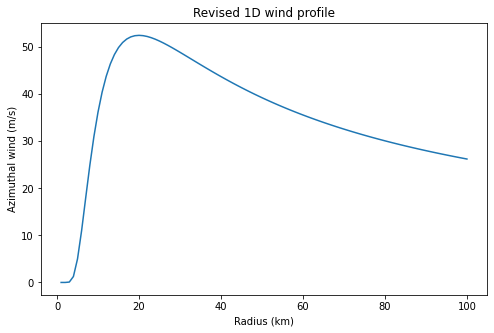

In [ ]:
# plot function in 1D
fig, ax = plt.subplots(figsize=(8,5))

n = 100
r = np.arange(0, n+1, 1)
Vs = compute_wind_profile(r, R, RHs, SST, R_Vms, Rn, Pcs, Pns, dPcst, Phi, Vt)
ax.plot(r, Vs)
ax.set(xlabel = "Radius (km)", 
       ylabel = "Azimuthal wind (m/s)",
       title = "Revised 1D wind profile")
plt.show()

# save plot
fig.savefig("Revised_1D_wind_profile.png", format = 'png')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in multiply


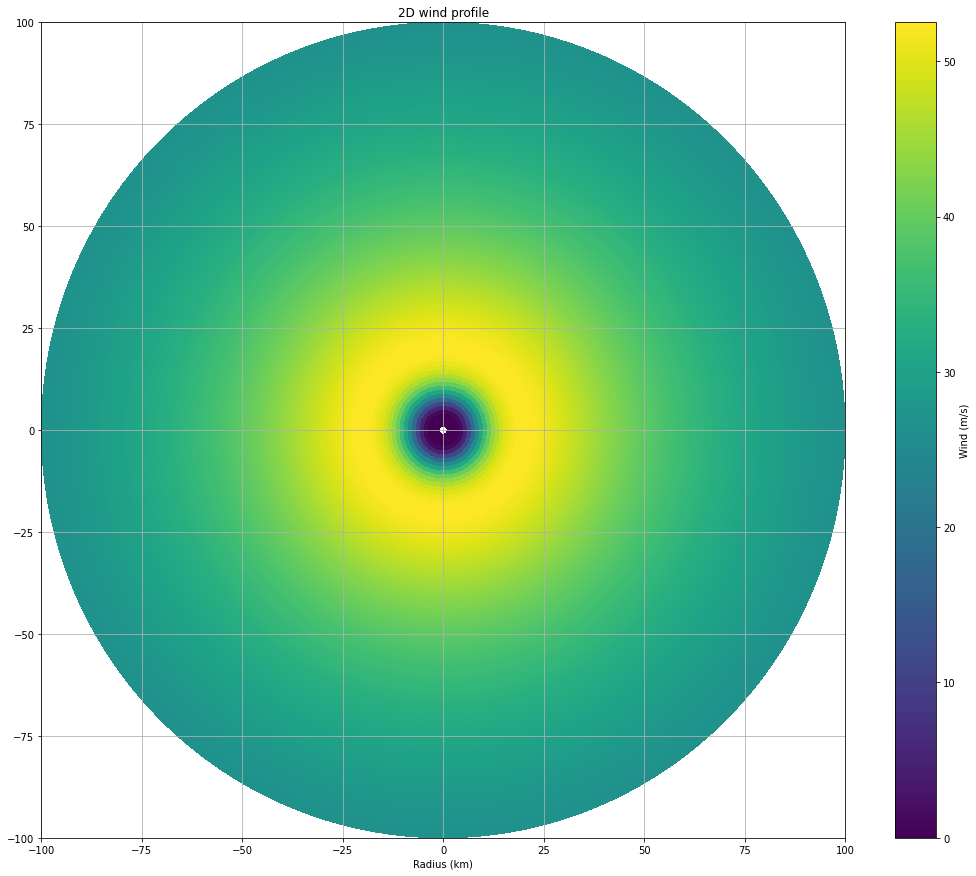

In [ ]:
# plot function in 2D
fig, ax = plt.subplots(figsize=(18, 15))

#r1, theta1 = cartesian_to_polar(n)

r1 = np.arange(0, n+1, 1)
#print("r1 shape: ", r1.shape)
phi = np.arange(361) * np.pi/180.
r1_grid, phi_grid = np.meshgrid(r1, phi)

xx_grid = r1_grid * np.cos(phi_grid + np.pi)
yy_grid = r1_grid * np.sin(phi_grid + np.pi)

Vs1 = compute_wind_profile(r1_grid, R, RHs, SST, R_Vms, Rn, Pcs, Pns, dPcst, Phi, Vt)
#print("Vs1 shape: ", Vs1.shape)

cs = plt.pcolormesh(yy_grid, xx_grid, Vs1)
plt.grid()
plt.colorbar(cs, label = "Wind (m/s)")
ax.set(xlabel = "Radius (km)",
       title = "2D wind profile")
plt.show()
#plt.imshow(Vs1, origin ='lower', interpolation ='nearest')

# save plot
fig.savefig("2D_wind_profile.png", format = 'png')

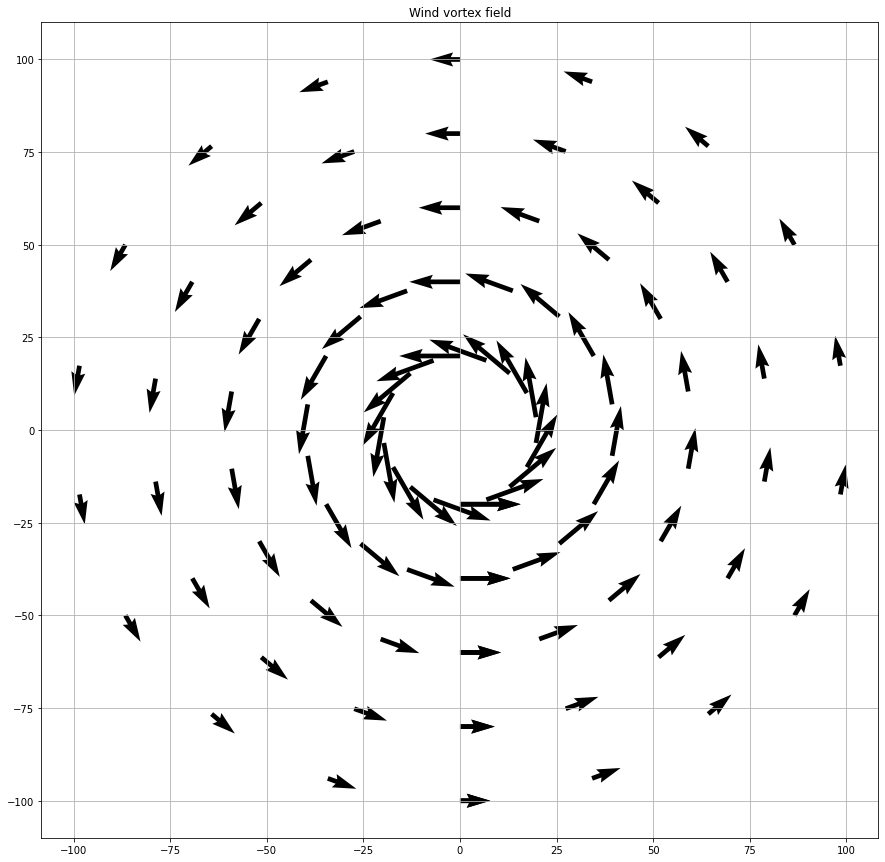

In [ ]:
# plot quiver
fig, ax = plt.subplots(figsize=(15, 15))

# velocity field of vortex 
u_Vs = Vs1 * np.sin(phi_grid + (90)*np.pi/180.)  # tangencial component
v_Vs = Vs1 * np.cos(phi_grid + (90)*np.pi/180.)  # normal component

dx=20; dy=20
# a[::n, ::n] -> beginning to end, counting by n
ax.quiver(yy_grid[::dx,::dy], xx_grid[::dx,::dy], u_Vs[::dx,::dy], v_Vs[::dx,::dy])
plt.title("Wind vortex field")
plt.grid()
plt.show()

# save plot
fig.savefig("Vortex.png", format = 'png')

##Parametric model extension to 2D

Taking the inflow angle into account.

In [ ]:
# inflow angle model
def inflow_model(r, theta, Vmax, Vs):

  # equation 2 (values according to Table 2)
  a_A0 = -0.90
  b_A0 = -0.09  # before it was -0.90
  c_A0 = -14.33
  A_alpha0 = a_A0*r + b_A0*Vmax + c_A0

  # equation 3a (values according to Table 2)
  a_A1 = 0.04
  b_A1 = 0.05
  c_A1 = 0.14
  A_alpha1 = -1. * A_alpha0 * (a_A1*r + b_A1*Vs + c_A1)

  # equation 3b (values according to Table 2)
  a_P1 = 6.88
  b_P1 = -9.60
  c_P1 = 85.31
  P_alpha1 = a_P1*r + b_P1*Vs + c_P1

  return A_alpha0 + A_alpha1 * np.cos(theta - P_alpha1 * np.pi/180.)

In [ ]:
# Vmax : storm intensity (m/s)
Vmax = 65
# Vs : storm motion speed (m/s)
Vs = 8
# Rmax : radius of maximum wind (km)
Rmax = 10

rnorm = np.arange(0, n+1, 1)/Rmax
#r_star = r1/Rmax
beta = np.arange(361) * np.pi/180.

rnorm_grid, beta_grid = np.meshgrid(rnorm, beta)

xx_grid = rnorm_grid * np.cos(beta_grid + np.pi)
yy_grid = rnorm_grid * np.sin(beta_grid + np.pi)

alpha_SR = inflow_model(rnorm_grid, beta_grid, Vmax, Vs)  # degrees
#alpha_SR = inflow_model(r_star, theta1, Vmax, Vs)

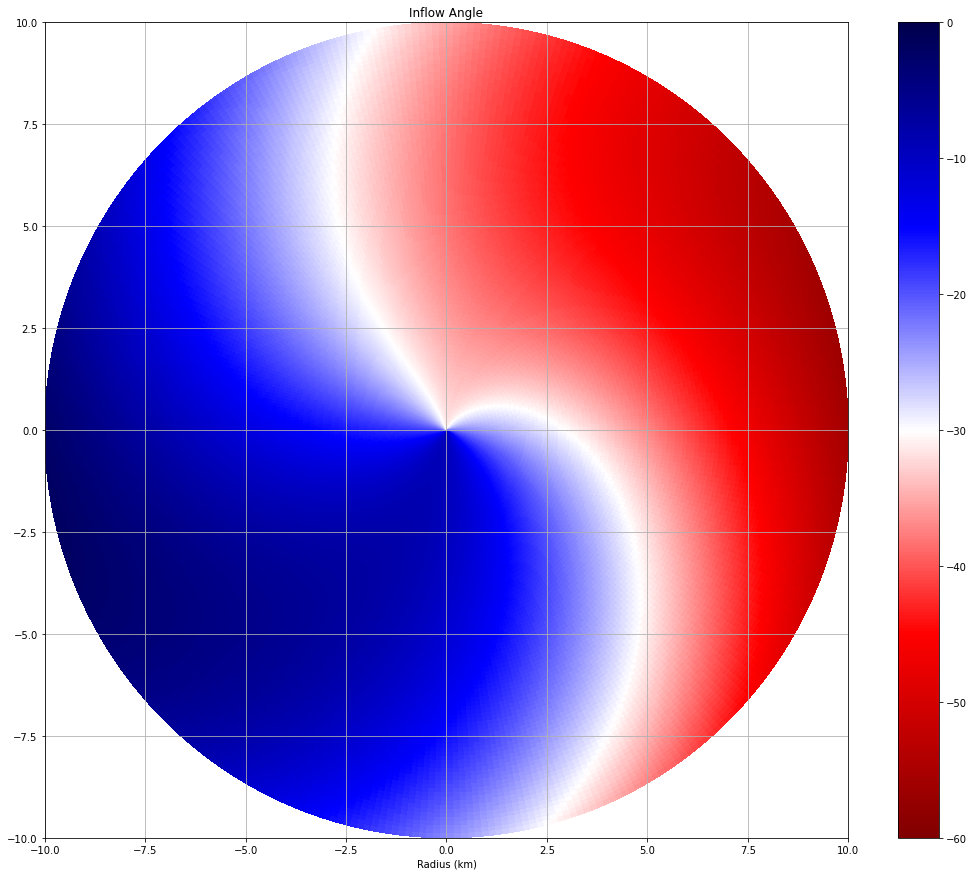

In [ ]:
# plot the inflow angle
fig, ax = plt.subplots(figsize=(18, 15))
cs = plt.pcolormesh(yy_grid, xx_grid, alpha_SR, cmap = 'seismic_r', vmax = 0, vmin = -60)
plt.grid()
plt.colorbar(cs)
ax.set(xlabel = "Radius (km)",
       title = "Inflow Angle")
plt.show()

# save plot
fig.savefig("Inflow_Angle.png", format = 'png')

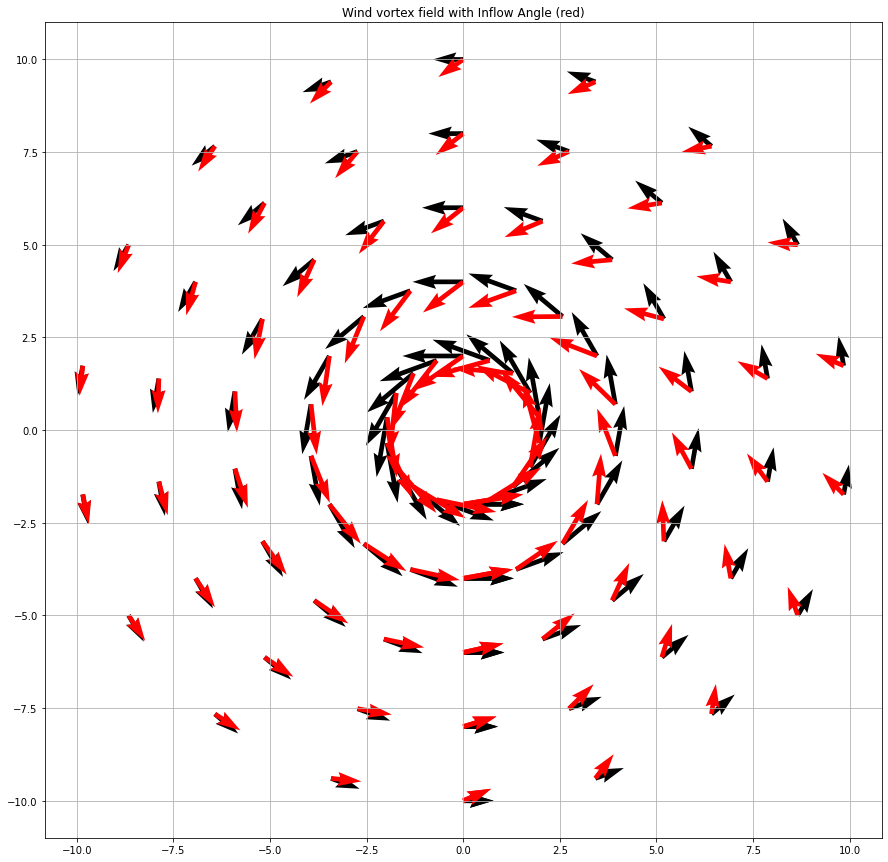

In [ ]:
# rotate u and v according to inflow angle (by only rotating the vector, the 
# absolute value of the wind speed is the same)

# velocity field of vortex 
u_alpha = Vs1 * np.sin(phi_grid + (90 + alpha_SR) * np.pi/180.)  # tangencial component
v_alpha = Vs1 * np.cos(phi_grid + (90 + alpha_SR) * np.pi/180.)  # normal component

# plot quiver
fig, ax = plt.subplots(figsize=(15, 15))

dx=20; dy=20
#cs = plt.pcolormesh(yy_grid, xx_grid, phi_grid+90*np.pi/180.)
ax.quiver(yy_grid[::dx,::dy], xx_grid[::dx,::dy], u_Vs[::dx,::dy], v_Vs[::dx,::dy])
ax.quiver(yy_grid[::dx,::dy], xx_grid[::dx,::dy], u_alpha[::dx,::dy], v_alpha[::dx,::dy], color = 'red')
plt.title("Wind vortex field with Inflow Angle (red)")
plt.grid()
#plt.colorbar(cs)
plt.show()

# save plot
fig.savefig("Vortex_with_IA.png", format = 'png')

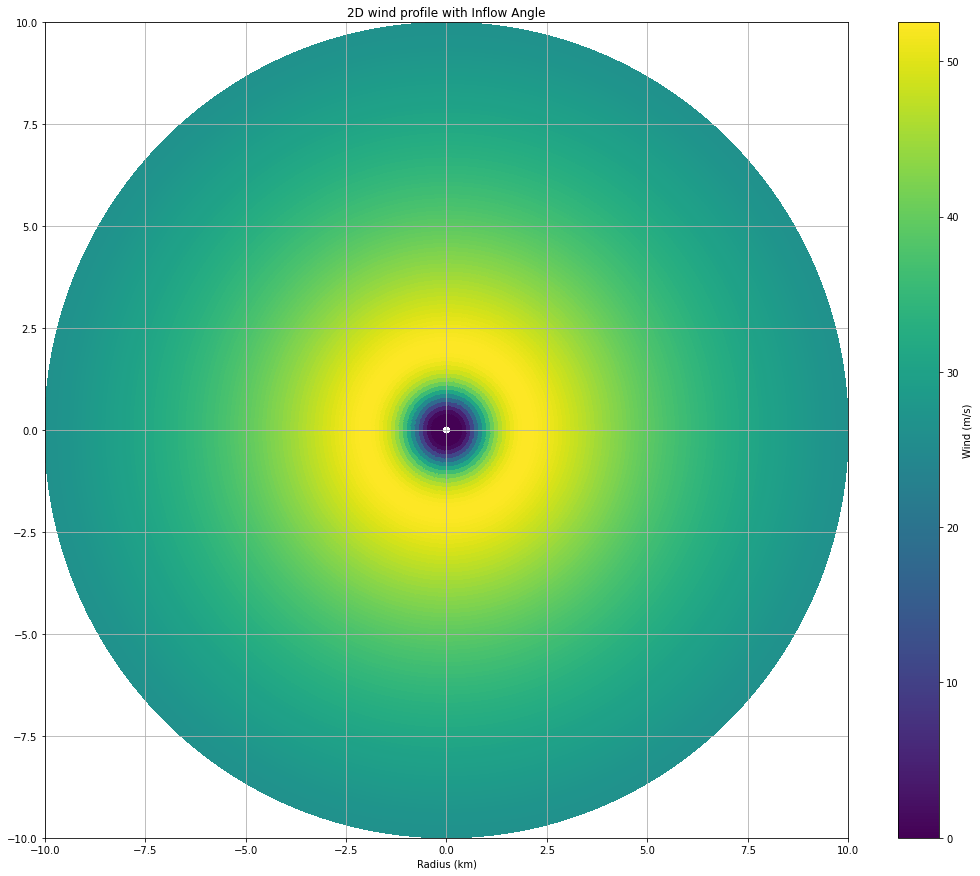

In [ ]:
# plot absolute wind speed profile
fig, ax = plt.subplots(figsize=(18, 15))

#xx_grid = r1_grid * np.cos(phi_grid + np.pi)
#yy_grid = r1_grid * np.sin(phi_grid + np.pi)

Vs2 = np.sqrt(u_alpha**2 + v_alpha**2)
#plt.imshow(Vs2.T, origin ='lower', interpolation ='nearest')
cs = plt.pcolormesh(yy_grid, xx_grid, Vs2)
plt.grid()
plt.colorbar(cs, label = "Wind (m/s)")
ax.set(xlabel = "Radius (km)",
       title = "2D wind profile with Inflow Angle")
plt.show()

# save plot
fig.savefig("2D_wind_profile_with_IA.png", format = 'png')

Taking the translation speed into account.

In [ ]:
# Vt : translation speed (m/s)
Vt = 15
# Dt : translation direction (degrees)
Dt = 180

# velocity field
u_Vt = Vt * np.cos(Dt * np.pi/180.)
v_Vt = Vt * np.sin(Dt * np.pi/180.)

# wind profile with translation speed
u_final = u_alpha + u_Vt
v_final = v_alpha + v_Vt

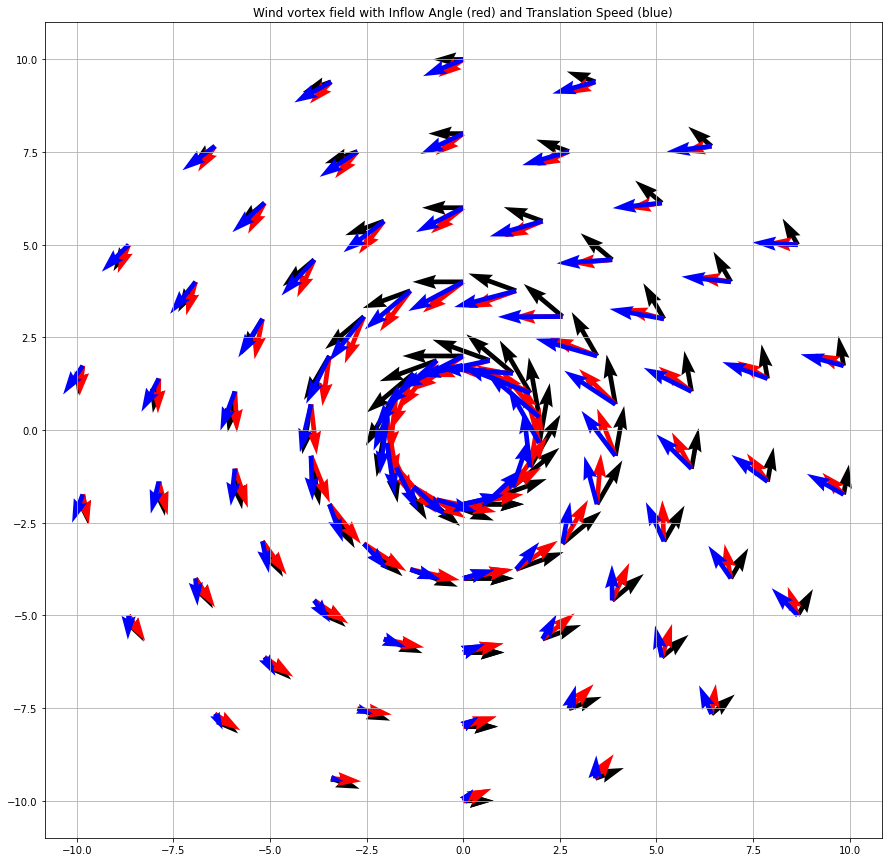

In [ ]:
# plot quiver
fig, ax = plt.subplots(figsize=(15, 15))

dx=20; dy=20
#cs = plt.pcolormesh(yy_grid, xx_grid, phi_grid+90*np.pi/180.)
ax.quiver(yy_grid[::dx,::dy], xx_grid[::dx,::dy], u_Vs[::dx,::dy], v_Vs[::dx,::dy])
ax.quiver(yy_grid[::dx,::dy], xx_grid[::dx,::dy], u_alpha[::dx,::dy], v_alpha[::dx,::dy], color = 'red')
ax.quiver(yy_grid[::dx,::dy], xx_grid[::dx,::dy], u_final[::dx,::dy], v_final[::dx,::dy], color = 'blue')
plt.title("Wind vortex field with Inflow Angle (red) and Translation Speed (blue)")
plt.grid()
#plt.colorbar(cs)
plt.show()

# save plot
fig.savefig("Vortex_with_IA_and_TS.png", format = 'png')

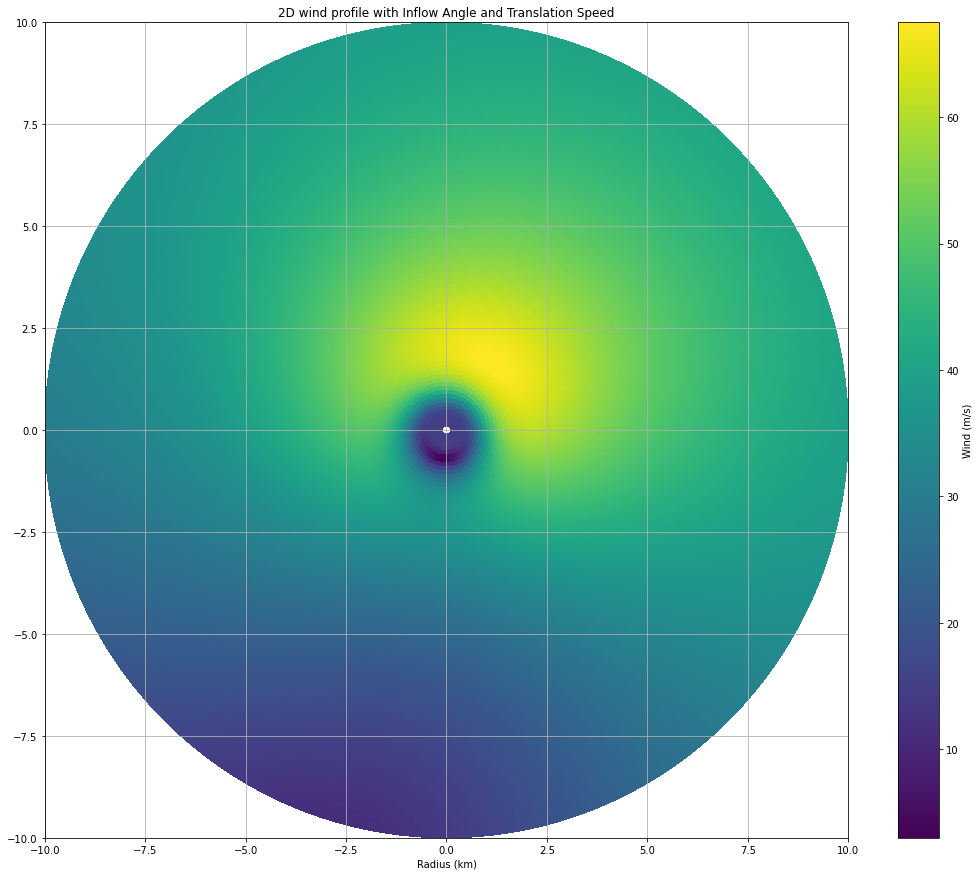

In [ ]:
# plot absolute wind speed profile
fig, ax = plt.subplots(figsize=(18, 15))

#xx_grid = r1_grid * np.cos(phi_grid + np.pi)
#yy_grid = r1_grid * np.sin(phi_grid + np.pi)

Vs3 = np.sqrt(u_final**2 + v_final**2)
#plt.imshow(Vs2.T, origin ='lower', interpolation ='nearest')
cs = plt.pcolormesh(yy_grid, xx_grid, Vs3)
plt.grid()
plt.colorbar(cs, label = "Wind (m/s)")
ax.set(xlabel = "Radius (km)",
       title = "2D wind profile with Inflow Angle and Translation Speed")
plt.show()

# save plot
fig.savefig("2D_wind_profile_with_IA_and_TS.png", format = 'png')